# 09 Free Bits

Random 0-1 random bits will be generated on the fly and processed by the network with no preprocessing done. Now the network has to learn how many random bits to take and then what to do with thim. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd drive/My\ Drive/CS281\ Final\ Project

## Package Loading

In [0]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from random import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
device = 'cuda'

from time import time
import pickle

## Manual Counter Implementation

In [0]:
def morris_count(seq, bits):
    '''seq is the sequence to count. bits is the set of random bits that were used'''
    x = 0
    seq_loc = 0
    bit_loc = 0
    seq = seq.squeeze()
    bits = bits.squeeze(2).squeeze(0)
    while seq_loc < len(seq):
        if bit_loc + x > len(bits):
            bits = torch.cat([bits, torch.randint_like(bits, low=0, high=2)])
        toss = bits[bit_loc:bit_loc+x]
        toss = toss.sum()
        bit_loc += x
        if toss == 0 and seq[seq_loc] == 1:
            x += 1
        seq_loc += 1
    return torch.tensor(x).double().cuda()


## Model Definition

In [0]:
class Counter():
    def __init__(self, hidden, input_size=1):
        '''hidden is the number of hidden variables to use per cell'''
        self.hidden = hidden
        

        self.count_lstm= nn.LSTM(hidden_size=hidden, batch_first=True, input_size=2).double().cuda() 
        self.bits_lstm = nn.LSTM(hidden_size=hidden, batch_first=True, input_size=hidden+1).double().cuda() 
        self.switch_lstm = nn.LSTM(hidden_size=hidden, batch_first=True, input_size=2*hidden+1).double().cuda() 
        self.bits_dense = torch.randn([hidden,1], dtype=float, device=device, requires_grad=True) 
        self.switch_dense = torch.randn([hidden,1], dtype=float, device=device, requires_grad=True) 
        self.count_dense = torch.randn([hidden,1], dtype=float, device=device, requires_grad=True) 

        params = list(self.count_lstm.parameters()) + list(self.switch_lstm.parameters()) + list(self.bits_lstm.parameters())
        params.append(self.switch_dense)
        params.append(self.count_dense)
        self.optimizer = optim.Adam(params)

    @staticmethod
    def convert_sequence(seq, input_size=1):
        '''converts a set of sequences with the same length from array or numpy into a correctly formatted tensor.'''
        seq = torch.tensor(seq, device=device).double()
        seq = seq.reshape([len(seq), -1, input_size])
        return seq

    def single_predict(self, seq):
        '''Takes a single sequence (length x 1), does a prediction, and outputs the prediction, the true count on the same random bits, and the loss'''
        bits = []
        output = []
        hidden = self.hidden

        out_s = torch.zeros([1,1,1]).double().cuda()
        out_c = torch.zeros([1,1,hidden]).double().cuda()
        out_b = torch.zeros([1,1,hidden]).double().cuda()

        state_s = [torch.zeros([1,1,hidden]).double().cuda(),torch.zeros([1,1,hidden]).double().cuda()]
        state_b = [torch.zeros([1,1,hidden]).double().cuda(),torch.zeros([1,1,hidden]).double().cuda()]
        state_c = [torch.zeros([1,1,hidden]).double().cuda(),torch.zeros([1,1,hidden]).double().cuda()]

        for i in range(seq.shape[0]):
            b_sum = torch.zeros([1,1,1]).double().cuda()
            s_sum = torch.zeros([1,1,1]).double().cuda()
            while s_sum < 1:
                rand = torch.randint(low=0, high=2, size=(1,1,1)).double().cuda() 
                bits.append(rand)
                inp_s = torch.cat([rand,out_c,out_b],2)
                inp_b = torch.cat([rand,out_c],2)
                out_s, state_s = self.switch_lstm(inp_s, state_s)
                out_b, state_b = self.bits_lstm(inp_b, state_b)
                s_sum += torch.sigmoid(out_s @ self.switch_dense)
                b_sum += torch.sigmoid(out_b @ self.bits_dense)
            inp_c = torch.cat([seq[None,i,None], b_sum], 2)
            out_c, state_c = self.count_lstm(inp_c, state_c)
            output.append(torch.sigmoid(out_c @ self.count_dense))

        output = torch.cat(output, 1)
        bits = torch.cat(bits, 1).int()
        count = output.sum()
        true = morris_count(seq, bits)
        loss = (count - true).pow(2)
        return loss, count, true

    def batch_predict(self, sequences):
        '''predicts on a batch of sequences which all have the same length'''
        loss = torch.tensor(0).double().cuda()
        for seq in sequences:
            loss += self.single_predict(seq)[0]
        return loss

    def predict_multilength(self, multilen_sequences):
        '''Takes a list of batches of tensors of different length. Predicts on each batch. Sums up the loss. Reduces to a single mean'''
        loss = torch.tensor(0, device=device).double()
        total= torch.tensor(0, device=device).double()
        for length in multilen_sequences:
            res    = self.batch_predict(length)
            total += length.shape[0]
            loss  += res.sum()
        return loss / total

    @staticmethod
    def true_sum(sequence):
        '''Determines the true sums of a batch of sequences to train against'''
        res = []
        for seq in sequence:
            res.append(morris_count(seq))
        res = np.array(res, dtype=float)
        return torch.tensor(res, device=device).double()

## Data Generation

In [0]:
def round_partition(p):
    '''Rounds a partition so that the sum of the partition equals the original sum'''
    rounded = np.round(p).astype(int)
    ind = len(rounded)-1
    while rounded.sum() < p.sum():
        rounded[ind] += 1
        ind -= 1
    return rounded

def generate_data(length, total):
    counts = np.random.dirichlet((np.arange(length)+1)**2) * total * 0.9
    counts = round_partition(counts)

    train_set = []
    val_set = []
    test_set = []
    for i in range(1,length+1):
        if counts[i-1] == 0:
            continue
        seqs = np.random.randint(0,2, size=[counts[i-1],i])
        seqs = np.unique(seqs, axis=0)[:,:,None]
        try:
            train, val = train_test_split(seqs, test_size=2/9, shuffle=True)
            train = Counter.convert_sequence(train)
            val = Counter.convert_sequence(val)
            train_set.append(train)
            val_set.append(val)
        except ValueError:
            train = Counter.convert_sequence(seqs)
            train_set.append(train)
            continue
    counts = np.random.dirichlet((np.arange(length, 2*length)+1)**2) * total * 0.1
    counts = round_partition(counts)

    for i in range(length):
        if counts[i] == 0:
            continue
        seqs = np.random.randint(0,2, size=[counts[i],i+length+1])
        seqs = np.unique(seqs, axis=0)[:,:,None]
        seqs = Counter.convert_sequence(seqs)
        test_set.append(seqs)

    return train_set, val_set, test_set


In [0]:
#generate all the strings and partition into train and test
length = 64
hidden = 10
depth = 100

output_folder = "Part-9-Outputs"

In [0]:
# train, val, test = generate_data(length,depth)

# with open("%s/Data.pickle"%output_folder, "wb") as f:
#     pickle.dump([train, val, test], f)

In [0]:
with open("%s/Data.pickle"%output_folder, "rb") as f:
    train, val, test = pickle.load(f)

In [0]:
trainsize = sum([x.shape[0] for x in train])
valsize = sum([x.shape[0] for x in val])
testsize = sum([x.shape[0] for x in test])
print(trainsize, valsize, testsize)

total = trainsize+valsize+testsize
print("Total:",total) 
print("Fraction %.3f %.3f %.3f"%(trainsize/total, valsize/total, testsize/total))

print("Train    string range: %d-%d"%(min([x.shape[1] for x in train]), max([x.shape[1] for x in train])))
print("Validate string range: %d-%d"%(min([x.shape[1] for x in val]), max([x.shape[1] for x in val])))
print("Test     string range: %d-%d"%(min([x.shape[1] for x in test]), max([x.shape[1] for x in test])))

63 27 10
Total: 100
Fraction 0.630 0.270 0.100
Train    string range: 23-64
Validate string range: 39-64
Test     string range: 119-128


## Model Training

In [0]:
#train over all the training data
model = Counter(hidden=hidden)

history = []
best = float('inf')
patience = 25
tol = 0.001
count = 0

In [0]:
start = time()

for epoch in range(1,1000000): 
    shuffle(train)
    shuffle(val)
    if epoch % 10 == 0:
        train_loss = model.predict_multilength(train).item()
        with torch.no_grad():
            val_loss = model.predict_multilength(val).item()
        history.append([train_loss, val_loss])
        print("Epoch: %5d. Train Loss: %7.3f. Validation Loss: %7.3f. Elapsed: %7.3f"%(epoch, train_loss, val_loss, (time()-start)/60))
        start = time()

        if val_loss + tol < best:
            best = val_loss
            count = 0
            torch.save(model, "%s/Model"%output_folder)

        else:
            count += 1
        if count >= patience:
            break

    #take the average loss over all the train data
    loss = model.predict_multilength(train)   
    #and update
    model.optimizer.zero_grad()
    loss.backward(retain_graph=True)
    model.optimizer.step()

# history = np.array(history)
# np.save("%s/Train-History"%output_folder, history)
# 
# #display testing results
# loss = model.predict_multilength(test)
# print("Average Test Loss:", loss.item())

## Results Evaluation

In [0]:
model = torch.load("%s/Model"%output_folder)

In [0]:
loss = model.predict_multilength(train)
print("Average Train Loss:", loss.item())
loss = model.predict_multilength(val)
print("Average Val   Loss:", loss.item())
loss = model.predict_multilength(test)
print("Average Test  Loss:", loss.item())

Average Train Loss: 1.1422592800364266
Average Val   Loss: 0.9524080828385917
Average Test  Loss: 11.97364098252961


In [0]:
res = []
for s in range(3):
    for chunk in [train, val, test][s]:
        length = chunk.shape[1]
        for sample in chunk:
            # sample = sample.unsqueeze(0)
            l,p,t = model.single_predict(sample)
            res.append([["Train", "Validate", "Test"][s],length, l.item(), p.item(), t.item()])

for length in range(65,128):
    #make extra test data
    for _ in range(5):
        seq = np.random.randint(0,2,size=(length,1))
        seq = torch.tensor(seq).double().cuda()
        l,p,t = model.single_predict(seq)
        res.append(["Test", length, l.item(), p.item(), t.item()])
res = pd.DataFrame(res, columns=["Partition", "Length", "Loss", "Predicted Count" ,"True Count"])
# res['Error'] = np.abs(res['Predicted Count'] - res['True Count'])

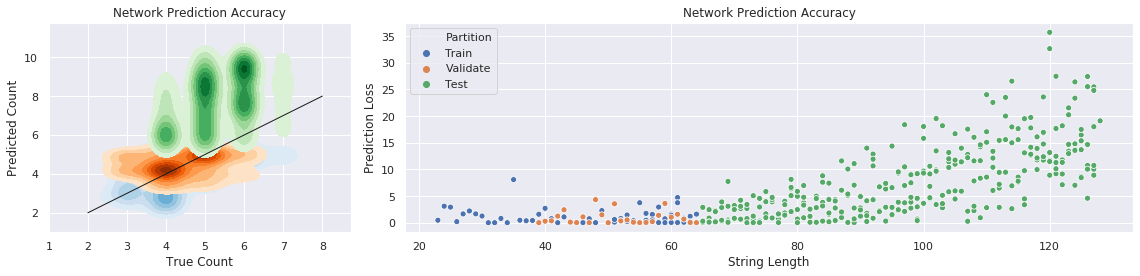

In [0]:
sns.set()
plt.figure(figsize=(16,4))
gs = GridSpec(1,2, width_ratios=[1,2.4]) 
plt.subplot(gs[0])
sns.kdeplot(data=res[res['Partition'] == 'Train']['True Count'], data2=res[res['Partition'] == 'Train']['Predicted Count'], \
            shade=True, cmap='Blues',shade_lowest=False)
sns.kdeplot(data=res[res['Partition'] == 'Validate']['True Count'], data2=res[res['Partition'] == 'Validate']['Predicted Count'], \
            shade=True, cmap='Oranges',shade_lowest=False)
sns.kdeplot(data=res[res['Partition'] == 'Test']['True Count'], data2=res[res['Partition'] == 'Test']['Predicted Count'], \
            shade=True, cmap='Greens',shade_lowest=False, label="Test")
plt.plot([2,8],[2,8], color='k', linewidth=1)

# plt.xlim([1,8])
# plt.ylim([1,10])
plt.title("Network Prediction Accuracy")
plt.subplot(gs[1])
plt.title("Network Prediction Accuracy")
sns.scatterplot(x="Length", y="Loss", hue="Partition", data=res)
plt.xlabel("String Length")
plt.ylabel("Prediction Loss")
plt.tight_layout()
plt.savefig('Figures/09-plot1', dpi=300)